## 시각화 자료 모음

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 로드
df = pd.read_csv('./data/another_data.csv')
df = df.drop('Unnamed: 0',axis=1)
df

,gender,living_area,age,job,education,income,child,experience,card,how_often_per_week,...,weekend_minute,weekday_reading_time,weekend_reading_time,total_reading_time,books_per_year,satisfaction,recommendation,present_use,future_use,churn
0,0,23,35,6,4,8,0,1,1,1,...,30,120,150,270,7,1,1,1,1,0
1,0,23,31,6,4,5,0,0,0,0,...,20,20,20,40,1,1,1,0,1,0
2,0,23,22,10,2,7,0,1,1,3,...,0,60,60,120,5,1,1,1,1,0
3,0,23,23,10,2,8,0,1,1,5,...,30,60,90,150,4,1,1,1,1,0
4,0,23,21,10,2,6,0,1,1,1,...,0,90,120,210,7,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,0,21,38,3,4,5,0,0,0,0,...,0,20,0,20,2,1,1,0,1,0
2566,0,21,59,9,4,9,1,1,1,0,...,30,30,30,60,6,1,1,1,1,0
2567,0,21,29,3,4,9,0,1,0,0,...,20,0,20,20,2,1,1,1,1,0
2568,0,14,35,6,4,7,0,1,1,0,...,0,30,60,90,6,1,1,1,1,0


<Axes: >

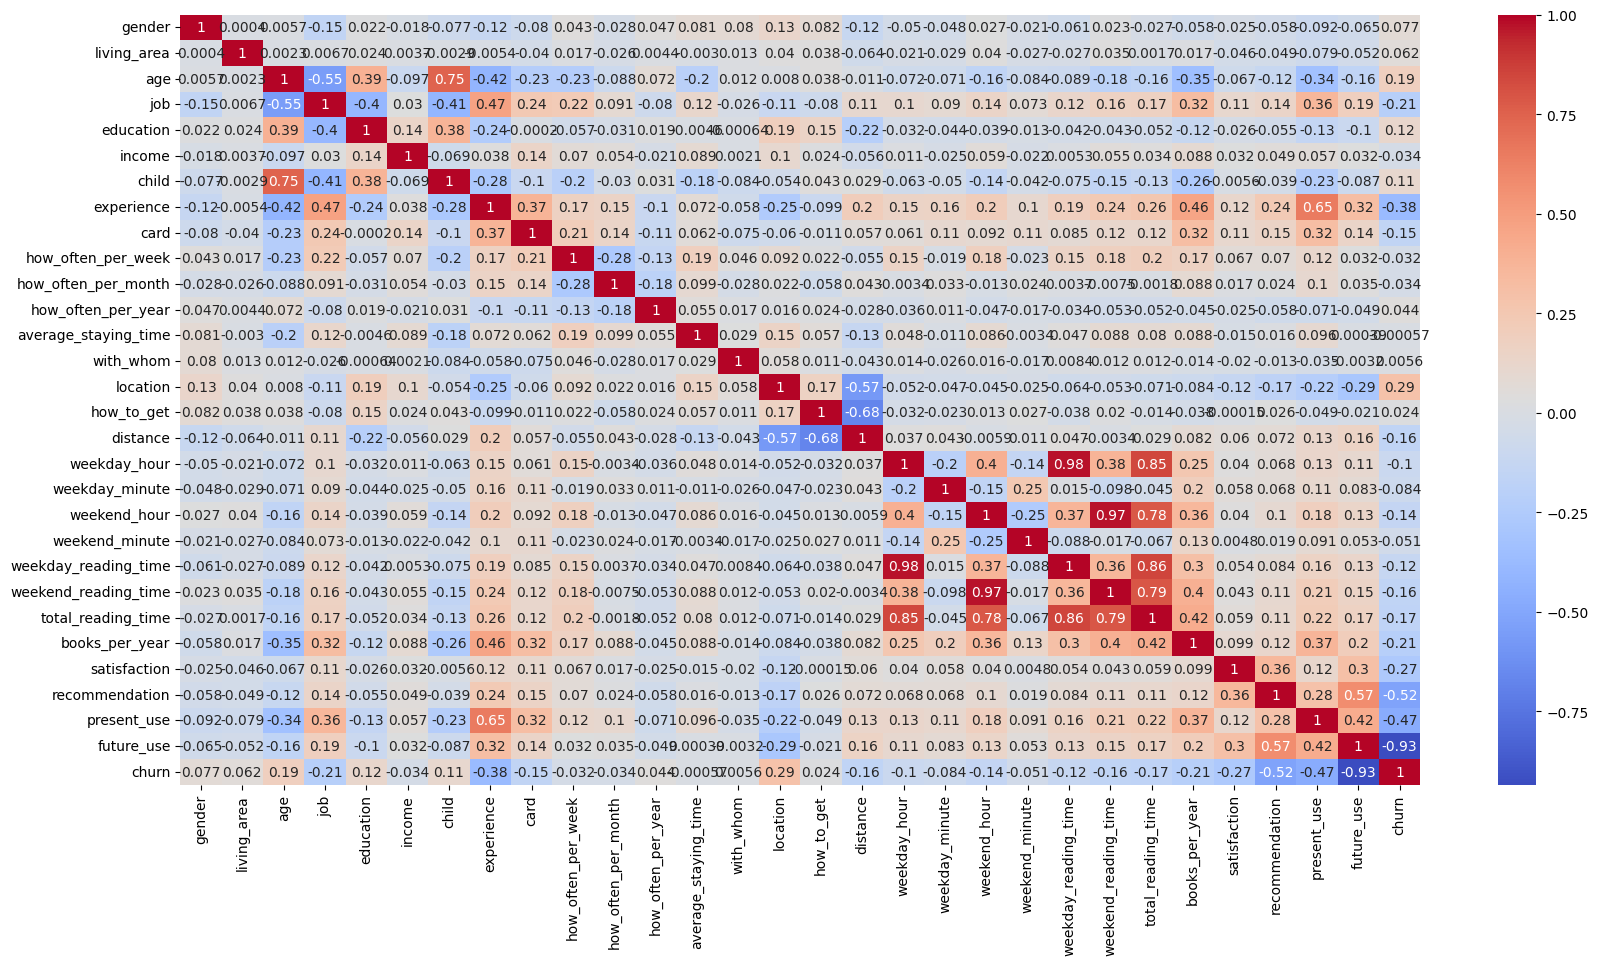

In [3]:
category = []

for column in df.columns:
    category.append(column)

corr_matrix = df[category].corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot=True)

In [4]:
df['churn'].value_counts()

churn
0    2297
1     273
Name: count, dtype: int64

In [5]:
# category = []
# aaa = 'gender', 'age', 'learning', 'income', 'job', 'living_area_grouped', 'total_reading_time', 'use_or_not', 'books_per_year', 'distance'

# for column in aaa:
#     category.append(column)

# corr_matrix = df[category].corr()

# plt.figure(figsize=(20,10))
# sns.heatmap(corr_matrix, cmap = 'coolwarm', annot=True)

In [6]:
df[['gender','living_area','age','job','education','income','child']].isna().sum()

gender         0
living_area    0
age            0
job            0
education      0
income         0
child          0
dtype: int64

In [7]:
df['experience'].value_counts()

experience
1    1401
0    1169
Name: count, dtype: int64

# 비상사태

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN # SMOTE와 ENN을 결합한 기법
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.font_manager as fm
import matplotlib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# 1. 탐색 공간 정의
search_space = {
    'rf_max_depth':        hp.quniform('rf_max_depth', 5, 15, 1),
    'rf_min_samples_leaf': hp.quniform('rf_min_samples_leaf', 1, 10, 1),
    'rf_n_estimators':     hp.quniform('rf_n_estimators', 100, 300, 50),

    'lgb_max_depth':       hp.quniform('lgb_max_depth', 5, 15, 1),
    'lgb_learning_rate':   hp.loguniform('lgb_learning_rate', np.log(0.005), np.log(0.1)),
    'lgb_reg_alpha':       hp.uniform('lgb_reg_alpha', 0.0, 1.0),
    'lgb_reg_lambda':      hp.uniform('lgb_reg_lambda', 0.0, 1.0),

    'xgb_max_depth':       hp.quniform('xgb_max_depth', 5, 15, 1),
    'xgb_learning_rate':   hp.loguniform('xgb_learning_rate', np.log(0.005), np.log(0.1)),
    'xgb_n_estimators':    hp.quniform('xgb_n_estimators', 100, 400, 50),
    'xgb_subsample':       hp.uniform('xgb_subsample', 0.6, 1.0),
    'xgb_colsample_bytree':hp.uniform('xgb_colsample_bytree', 0.6, 1.0)
}


# --- 데이터 준비 (이전과 동일) ---
area_code_to_group_map = {
    # 그룹 1: 고소득/핵심업무 (강남,서초,송파,종로,중구,영등포,용산)
    1: 1, 15: 1, 18: 1,
    23: 1, 24: 1, 20: 1, 21: 1,
    # 그룹 2: 중산층/주거중심 (강동,마포,서대문,성동,광진,동작,양천)
    2: 2, 13: 2, 14: 2, 16: 2,
    6: 2, 12: 2, 19: 2,
    # 그룹 3: 대규모 주거단지 (그 외)
    3: 3, 4: 3, 5: 3, 7: 3,
    8: 3, 9: 3, 10: 3, 11: 3,
    17: 3, 22: 3, 25: 3
}

df['living_area_grouped'] = df['living_area'].map(area_code_to_group_map)

X = df[['gender', 'age', 'education', 'income', 'job', 'living_area_grouped', 'experience', 'distance']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

# --- 파이프라인 재구성: SMOTEENN + Stacking ---
numerical_features = ['age']
categorical_features = ['living_area_grouped', 'job']
ordinal_features = ['gender', 'education', 'income', 'experience', 'distance']

# 1. 전처리기 (동일)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Normalizer(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', 'passthrough', ordinal_features)
    ],
    remainder='passthrough'
)

# 2. 목적 함수 정의
def objective(params):
    # 하이퍼파라미터 형변환 (정수형 파라미터 변환)
    params = {k: int(v) if 'depth' in k or 'n_estimators' in k or 'min_samples_leaf' in k else v
              for k, v in params.items()}

    rf_model = RandomForestClassifier(
        max_depth=params['rf_max_depth'],
        min_samples_leaf=params['rf_min_samples_leaf'],
        n_estimators=params['rf_n_estimators'],
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    lgb_model = LGBMClassifier(
        max_depth=params['lgb_max_depth'],
        learning_rate=params['lgb_learning_rate'],
        reg_alpha=params['lgb_reg_alpha'],
        reg_lambda=params['lgb_reg_lambda'],
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        class_weight='balanced'
    )

    xgb_model = xgb.XGBClassifier(
        max_depth=params['xgb_max_depth'],
        learning_rate=params['xgb_learning_rate'],
        n_estimators=params['xgb_n_estimators'],
        subsample=params['xgb_subsample'],
        colsample_bytree=params['xgb_colsample_bytree'],
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )

    # 스태킹 파이프라인 구성
    stacking_model = ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTEENN(random_state=42)),
        ('classifier', StackingClassifier(
            estimators=[
                ('rf', rf_model),
                ('lgb', lgb_model),
                ('xgb', xgb_model)
            ],
            final_estimator=RidgeClassifier(class_weight='balanced', random_state=42),
            cv=5,
            n_jobs=-1
        ))
    ])

    # 교차 검증
    score = cross_val_score(stacking_model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    mean_score = np.mean(score)

    return {'loss': -mean_score, 'status': STATUS_OK}

# 3. HyperOpt 실행
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best parameters found:", best_params)

100%|██████████| 50/50 [04:00<00:00,  4.80s/trial, best loss: -0.8625558799502876]
Best parameters found: {'lgb_learning_rate': np.float64(0.006884053729833574), 'lgb_max_depth': np.float64(7.0), 'lgb_reg_alpha': np.float64(0.0029881393721375112), 'lgb_reg_lambda': np.float64(0.701655134679971), 'rf_max_depth': np.float64(15.0), 'rf_min_samples_leaf': np.float64(5.0), 'rf_n_estimators': np.float64(250.0), 'xgb_colsample_bytree': np.float64(0.6431977937194586), 'xgb_learning_rate': np.float64(0.008078887219478185), 'xgb_max_depth': np.float64(9.0), 'xgb_n_estimators': np.float64(300.0), 'xgb_subsample': np.float64(0.7602633170965003)}


In [9]:
# best_params 적용 후 최종 학습
best_params_int = {k: int(v) if 'depth' in k or 'n_estimators' in k or 'min_samples_leaf' in k else v
                   for k, v in best_params.items()}

# 최적 파라미터 기반 개별 모델 생성
rf_best = RandomForestClassifier(
    max_depth=best_params_int['rf_max_depth'],
    min_samples_leaf=best_params_int['rf_min_samples_leaf'],
    n_estimators=best_params_int['rf_n_estimators'],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

lgb_best = LGBMClassifier(
    max_depth=best_params_int['lgb_max_depth'],
    learning_rate=best_params_int['lgb_learning_rate'],
    reg_alpha=best_params_int['lgb_reg_alpha'],
    reg_lambda=best_params_int['lgb_reg_lambda'],
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    class_weight='balanced'
)

xgb_best = xgb.XGBClassifier(
    max_depth=best_params_int['xgb_max_depth'],
    learning_rate=best_params_int['xgb_learning_rate'],
    n_estimators=best_params_int['xgb_n_estimators'],
    subsample=best_params_int['xgb_subsample'],
    colsample_bytree=best_params_int['xgb_colsample_bytree'],
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)

# 최종 파이프라인
final_best_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', StackingClassifier(
        estimators=[
            ('rf', rf_best),
            ('lgb', lgb_best),
            ('xgb', xgb_best)
        ],
        final_estimator=RidgeClassifier(class_weight='balanced', random_state=42),
        cv=5,
        n_jobs=-1
    ))
])

# 학습
final_best_pipeline.fit(X_train, y_train)

# 평가
y_pred_best = final_best_pipeline.predict(X_test)


print(final_best_pipeline.score(X_train, y_train))
print(final_best_pipeline.score(X_test, y_test))
print("=== 최종 모델 성능 ===")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

0.8098249027237354
0.7723735408560312
=== 최종 모델 성능 ===
              precision    recall  f1-score   support

           0       0.97      0.76      0.86       459
           1       0.30      0.84      0.44        55

    accuracy                           0.77       514
   macro avg       0.64      0.80      0.65       514
weighted avg       0.90      0.77      0.81       514

Confusion Matrix:
[[351 108]
 [  9  46]]


c:\Users\Playdata\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Playdata\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [10]:
from joblib import dump

dump(final_best_pipeline, 'final_model.joblib')

['final_model.joblib']